In [272]:
import numpy as np
import torch
from soma import aims, aimsalgo
import matplotlib.pyplot as plt

In [263]:
class TrimDepthTensor(object):
    """
    Trim depth based on distbottom.
    Set max_distance to 0 to remove bottom only.
    Set max_distance to -1 to remove nothing.
    """

    def __init__(self, sample_distbottom, sample_foldlabel,
                 max_distance, input_size, keep_top, uniform):
        self.max_distance = max_distance
        self.input_size = input_size
        self.sample_distbottom = sample_distbottom
        self.sample_foldlabel = sample_foldlabel
        self.keep_top=keep_top
        self.uniform=uniform
    
    def __call__(self, tensor_skel):
        #log.debug(f"Shape of tensor_skel = {tensor_skel.shape}")
        arr_skel = tensor_skel.numpy()
        arr_distbottom = self.sample_distbottom.numpy()
        arr_foldlabel = self.sample_foldlabel.numpy()

        # log.debug(f"arr_skel.shape = {arr_skel.shape}")
        # log.debug(f"arr_foldlabel.shape = {arr_foldlabel.shape}")
        assert (arr_skel.shape == arr_distbottom.shape)
        assert (self.max_distance >= -1)

        if self.uniform:
            arr_trimmed = arr_skel.copy()
            # get random threshold
            threshold = np.random.randint(-1, self.max_distance+1)
            # mask skel with thresholded distbottom
            if self.keep_top:
                arr_trimmed[np.logical_and(arr_distbottom<=threshold, arr_skel!=35)]=0
            else:
                arr_trimmed[arr_distbottom<=threshold]=0
        else:
            # select a threshold for each branch
            arr_trimmed_branches = np.zeros(arr_skel.shape)
            indexes =  np.unique(
                                np.mod(arr_foldlabel,
                                        np.full(arr_foldlabel.shape, fill_value=1000))
                                )
            assert (len(indexes)>1), 'No branch in foldlabel'
            for index in indexes[1:]:
                arr_trimmed = arr_skel.copy()
                mask_branch = np.mod(arr_foldlabel,
                                    np.full(arr_foldlabel.shape, fill_value=1000))==index
                threshold = np.random.randint(-1, self.max_distance+1)
                if self.keep_top:
                    #print(np.sum(np.logical_and(arr_distbottom<=threshold, arr_skel!=35)))
                    arr_trimmed[np.logical_and(arr_distbottom<=threshold, arr_skel!=35)]=0
                else:
                    arr_trimmed[arr_distbottom<=threshold]=0
                arr_trimmed_branches += (arr_trimmed * mask_branch)
            arr_trimmed = arr_trimmed_branches.copy()

        

        arr_trimmed = arr_trimmed.astype('float32')

        return torch.from_numpy(arr_trimmed)

In [264]:
dir_crop = '/volatile/jl277509/data/UkBioBank/crops/2mm/CINGULATE/mask/'
subject = 'sub-6024754'
skel = aims.read(dir_crop+'Rcrops/'+subject+'_cropped_skeleton.nii.gz')
skel = skel.np
skel = torch.tensor(skel)
foldlabel = aims.read(dir_crop+'Rlabels/'+subject+'_cropped_foldlabel.nii.gz')
foldlabel = foldlabel.np
foldlabel = torch.tensor(foldlabel)
distbottom = aims.read(dir_crop+'Rdistbottom/'+subject+'_cropped_distbottom.nii.gz')
distbottom = distbottom.np
distbottom = torch.tensor(distbottom)

In [268]:
trimdepth = TrimDepthTensor(distbottom, foldlabel,
                            max_distance=2,
                            input_size=[1, 16, 37, 37],
                            keep_top=True,
                            uniform=False)

In [269]:
view1 = trimdepth(skel)

In [331]:
skel_nifti = aims.read(dir_crop+'Rcrops/'+subject+'_cropped_skeleton.nii.gz')
aims.write(skel_nifti, f'/volatile/jl277509/data/test_augmentations/{subject}_cingulate.nii.gz')
mesher = aimsalgo.Mesher()
mesher.setVerbose(False)
mesher.setDecimation(100.0, 5, 3, 180.0)
mesher.setMinFacetNumber(50)
mesh = aims.AimsSurfaceTriangle()
# bck est le bucket a mailler
mesher.getBrain(skel_nifti, mesh)
aims.write(mesh, f'/volatile/jl277509/data/test_augmentations/{subject}_cingulate.mesh')

In [324]:
print(np.unique(skel_nifti.np))
print(np.sum(skel_nifti))
print(skel_nifti.np.dtype)
print(skel_nifti.shape)

[  0  30  35  60 100 120]
17665
int16
(16, 37, 37, 1)


In [323]:
print(np.unique(view_nifti.np))
print(np.sum(view_nifti))
print(view_nifti.np.dtype)
print(view_nifti.shape)

[  0  30  35  60 100 120]
14245
int16
(16, 37, 37, 1)


In [309]:
view_np = (view1.numpy()).astype(np.int16)
view_nifti = aims.Volume(view_np)
aims.write(view_nifti, f'/volatile/jl277509/data/test_augmentations/{subject}_cingulate_trimedpeth.nii.gz')
mesher = aimsalgo.Mesher()
mesher.setVerbose(False)
mesher.setDecimation(100.0, 5, 3, 180.0)
mesher.setMinFacetNumber(50)
mesh = aims.AimsSurfaceTriangle()
# bck est le bucket a mailler
mesher.getBrain(view_nifti, mesh)
aims.write(mesh, f'/volatile/jl277509/data/test_augmentations/{subject}_cingulate_trimdepth.mesh')

In [270]:
print(np.sum(view1.numpy().astype(bool)))

273


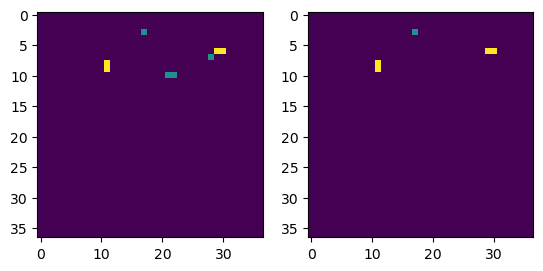

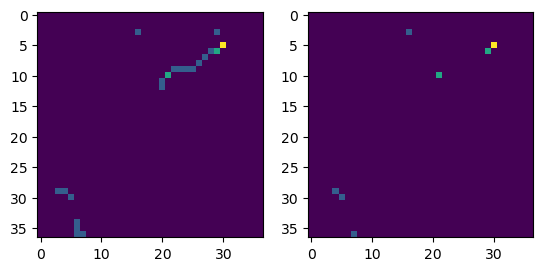

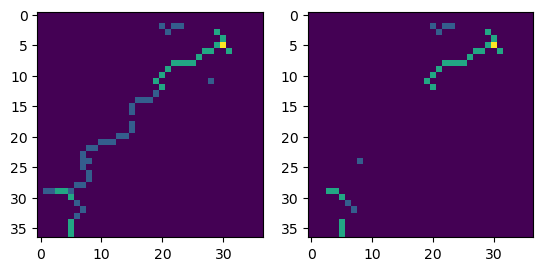

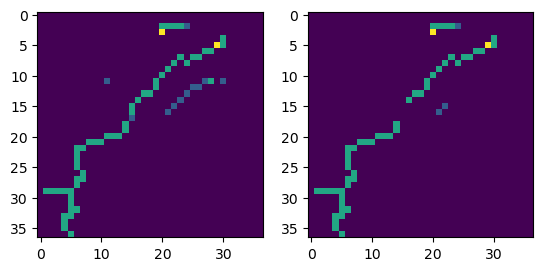

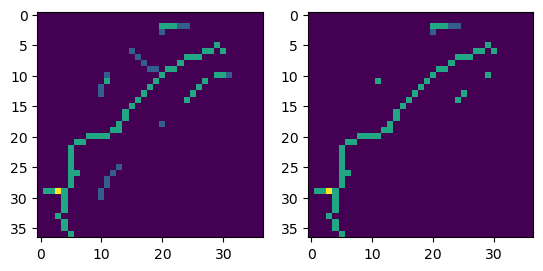

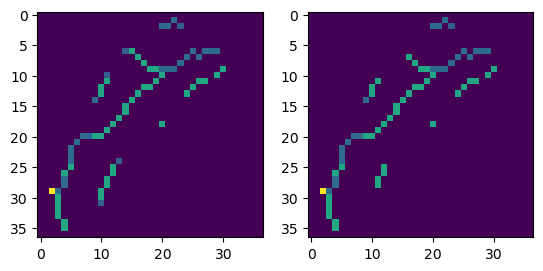

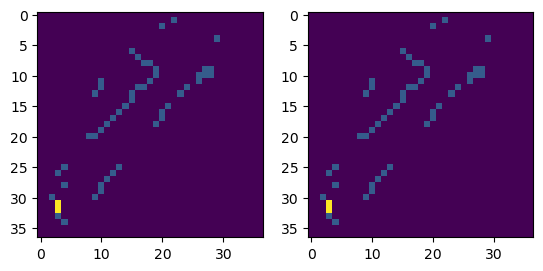

In [271]:
for idx in range(5,12):
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(skel.numpy()[idx,:,:,0])
    axs[1].imshow(view1.numpy()[idx,:,:,0])
    plt.show()